### Documentación

Problemas interesantes para Aprendizaje por refuerzo
 * Gymnasium: https://gymnasium.farama.org/environments/box2d/

## Instalación

!pip install gymnasium  
!pip install gymnasium[box2d] 

## Acciones adicionales

### En macos

pip uninstall swig  
xcode-select -—install (si no se tienen ya)  
pip install swig  / sudo port install swig-python
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas  

### en Windows

Si da error, se debe a la falta de la versión correcta de Microsoft Visual C++ Build Tools, que es una dependencia de Box2D. Para solucionar este problema, puede seguir los siguientes pasos:  
 * Descargar Microsoft Visual C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro de la app, seleccione la opción "Herramientas de compilación de C++" para instalar.
 * Reinicie su sesión en Jupyter Notebook.
 * Ejecute nuevamente el comando !pip install gymnasium[box2d] en la línea de comandos de su notebook.

In [2]:
# prueba lunar lander por humano

import gymnasium as gym

env = gym.make("LunarLander-v2", render_mode="rgb_array")

import numpy as np
import pygame
import gymnasium.utils.play

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}
gymnasium.utils.play.play(env, zoom=3, keys_to_action=lunar_lander_keys, noop=0)

: 

In [1]:
!pip install gymnasium[box2d]

  Using cached pygame-2.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0


In [10]:
import concurrent
import random
from MLP import MLP
import math
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v2")

class Genetic_Algorithm():
        
    def __init__(self, N=100, pcross=1/80, pmut=0.1, n_iter=5, n_tour=4, num_exp=1, elitism=1, bounds=[-20, 20]):
        self.MLP = MLP([8, 6, 4])
        self.N = N # Tamaño de la población
        self.pop = self.create_pop() # Población
        self.pcross = pcross # Probabilidad de cruce
        self.pmut = pmut # Probabilidad de mutación
        self.n_iter = n_iter # Numero de iteraciones
        self.n_tour = n_tour # Número de participantes en el torneo
        self.elitism = elitism # Número de individuos que pasan directamente a la siguiente generación
        self.num_exp = num_exp # Número de experimentos por individuo
        self.bounds = bounds

    def create_pop(self):
        """ Crea una población de N individuos codificados en modo locus """
        chromosome_len = len(self.MLP.to_chromosome())
        pop = [[random.uniform(-math.pi, math.pi) for _ in range(chromosome_len)] for _ in range(self.N)]
        return pop

    def mutate(self, chromosome):
        for i in range(len(chromosome)):
            if random.random() < self.pmut:
                chromosome[i] = random.uniform(self.bounds[0], self.bounds[1])
        return chromosome
    
    def crossover_uniform(self, parent1, parent2):
        """Realiza un crossover uniforme entre dos padres."""
        
        for i in range(len(parent1)):
            beta = random.random()
            if random.random() < self.pcross:
                parent1[i], parent2[i] = beta * parent1[i] + (1 - beta) * parent2[i], (1 - beta) * parent1[i] + beta * parent2[i]

        return parent1, parent2

    def tournament(self, fitness):
        """ Selección de padres por torneo """
        participants = random.sample(self.pop, self.n_tour)
        best = None
        for participant in participants:
            if best is None:
                best = participant
            elif (fitness[self.pop.index(participant)] < fitness[self.pop.index(best)]):
                best = participant
        return best
    
    def create_children(self, fitness):
        children = []
        while len(children) < self.N:
            parent1 = self.tournament(fitness)
            parent2 = parent1
            while parent1 == parent2:
                parent2 = self.tournament(fitness)
            child1, child2 = self.crossover_uniform(parent1, parent2)

            self.mutate(child1)
            self.mutate(child2)

            children.append(child1)
            children.append(child2)

        return children
    
    def policy (self, observation):
        s = self.MLP.forward(observation)
        action = np.argmax(s)
        return action
    
    def run (self):
        #observation, info = env.reset(seed=42)
        observation, info = env.reset()
        ite = 0
        racum = 0
        while True:
            action = self.policy(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            
            racum += reward

            if terminated or truncated:
                r = (racum+200) / 500
                return racum
     
    def fitness(self, chromosome):
        """ Evalua un cromosoma """
        self.MLP.from_chromosome(chromosome)

        r = 0
        for _ in range(self.num_exp):
            r += self.run()
    
        return r/self.num_exp
    
    def plot_evolution(self, fitness_history):
        plt.plot(fitness_history['best'], label='Best Fitness')
        plt.plot(fitness_history['mean'], label='Mean Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Fitness Evolution Over Generations')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evolve(self):
        """Evoluciona la población usando algoritmo genético."""

        fitness_list = [self.fitness(chromosome) for chromosome in self.pop]
        fitness_history = {'best': [max(fitness_list)], 'mean': [np.mean(fitness_list)]}

        best_chromosome = self.pop[np.argmax(fitness_list)]
        best_fitness = max(fitness_list)
        
        for generation in range(self.n_iter):
            
            # Ordenar los individuos de la generación anterior
            sorted_indices = np.argsort(fitness_list)[::-1]  

            # Crear nueva generación y calcular su fitness
            children = self.create_children(fitness_list)
            #fitness_children = [self.fitness(chromosome) for chromosome in children]
            with concurrent.futures.ProcessPoolExecutor() as executor:
                fitness_children = list(executor.map(self.fitness, children))

            # Elitismo: seleccionar los N mejores individuos
            if self.elitism:    
                new_pop = [self.pop[i] for i in sorted_indices[:self.elitism]] 
                fitness_list = [fitness_list[i] for i in sorted_indices[:self.elitism]]

                new_pop = new_pop + [children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]
                fitness_list = fitness_list + [fitness_children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]
            
            else:
                new_pop = [children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]
                fitness_list = [fitness_children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]

            # Actualizar la población
            self.pop = new_pop

            # Registra el mejor fitness y el fitness promedio
            fitness_history['best'].append(max(fitness_list))
            fitness_history['mean'].append(np.mean(fitness_list))

            if max(fitness_list) > best_fitness:
                best_chromosome = self.pop[np.argmax(fitness_list)]
                best_fitness = max(fitness_list)

            # Seleccionar los N mejores individuos
            if generation % 10 == 0:           
                print("Generación", generation, "Fitness", max(fitness_list))
                print("Mejor fitness: ", best_fitness ," Cromosoma: ", best_chromosome)
        
        self.plot_evolution(fitness_history)
            
        return best_chromosome, best_fitness      
        

Generación 0 Fitness -127.58658655764275
Mejor fitness:  -123.31888100850999  Cromosoma:  [-2.5582864859400747, 2.6886570247835513, -3.089203065636081, -3.0471211076945193, 0.980776649012542, 0.5897820286782309, 3.0438338661568576, 1.0164392823877, -2.8256057116899207, -2.6413004817312697, 2.2811054642617057, -3.0381732787970406, -0.93656765598999, -1.431772063179616, 1.7157956028007586, -0.8859833371687089, -0.9340372127785486, -1.8228734955902683, -0.9989059703477792, 1.1339708612180672, -1.0487029399233254, 0.7394870255289012, -1.0863215157494763, -0.3418800108886262, 2.4342287517709256, 2.9439943048210004, -1.7377964736562037, 3.1189002392687337, 2.6995012635604194, 1.9937737243611018, -2.3566542383332623, -0.6905749439386999, -0.2972521447678269, 2.6306802581890967, 1.8940387240431749, 1.9358981174995273, -2.279513422887611, -0.32593501227249266, -0.4518413514462063, 2.376087761517943, -3.0465227080283577, 2.440888444561409, 1.9537958245638718, 0.9856329852575652, -2.7234030619023

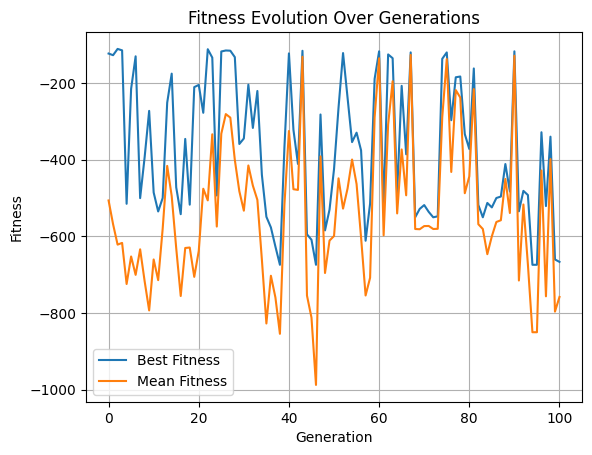

In [13]:
GA = Genetic_Algorithm(N=100, pcross=0.6, pmut=1/82, n_iter=100, n_tour=2, elitism=0, num_exp=40, bounds=[-10, 10])
chromosome, fitness = GA.evolve()

In [ ]:
import concurrent
import random
from MLP import MLP
import math
import gymnasium as gym
import numpy as np

env = gym.make("LunarLander-v2")

class Genetic_Algorithm():
        
    def __init__(self, N=100, pcross=1/80, pmut=0.1, n_iter=5, n_tour=4, num_exp=1, elitism=1):
        self.MLP = MLP([8, 6, 4])
        self.N = N # Tamaño de la población
        self.pop = self.create_pop() # Población
        self.pcross = pcross # Probabilidad de cruce
        self.pmut = pmut # Probabilidad de mutación
        self.n_iter = n_iter # Numero de iteraciones
        self.n_tour = n_tour # Número de participantes en el torneo
        self.elitism = elitism # Número de individuos que pasan directamente a la siguiente generación
        self.num_exp = num_exp # Número de experimentos por individuo

    def create_pop(self):
        """ Crea una población de N individuos codificados en modo locus """
        chromosome_len = len(self.MLP.to_chromosome())
        pop = [[random.uniform(-math.pi, math.pi) for _ in range(chromosome_len)] for _ in range(self.N)]
        return pop

    def mutate(self, chromosome):
        for i in range(len(chromosome)):
            if random.random() < self.pmut:
                chromosome[i] = random.uniform(-20, 20)
        return chromosome
    
    def crossover_uniform(self, parent1, parent2):
        """Realiza un crossover uniforme entre dos padres."""
        
        for i in range(len(parent1)):
            beta = random.random()
            if random.random() < self.pcross:
                parent1[i], parent2[i] = beta * parent1[i] + (1 - beta) * parent2[i], (1 - beta) * parent1[i] + beta * parent2[i]

        return parent1, parent2

    def tournament(self, fitness):
        """ Selección de padres por torneo """
        participants = random.sample(self.pop, self.n_tour)
        best = None
        for participant in participants:
            if best is None:
                best = participant
            elif (fitness[self.pop.index(participant)] < fitness[self.pop.index(best)]):
                best = participant
        return best
    
    def create_children(self, fitness):
        children = []
        while len(children) < self.N:
            parent1 = self.tournament(fitness)
            parent2 = parent1
            while parent1 == parent2:
                parent2 = self.tournament(fitness)
            child1, child2 = self.crossover_uniform(parent1, parent2)

            self.mutate(child1)
            self.mutate(child2)

            children.append(child1)
            children.append(child2)

        return children
    
    def policy (self, observation):
        s = self.MLP.forward(observation)
        action = np.argmax(s)
        return action
    
    def run (self):
        try:
            #observation, info = env.reset(seed=42)
            observation, info = env.reset()
            ite = 0
            racum = 0
            while True:
                action = self.policy(observation)
                observation, reward, terminated, truncated, info = env.step(action)
                
                racum += reward

                if terminated or truncated:
                    r = (racum+200) / 500
                    return racum
        except Exception as e:
            print(f"Error during run: {e}")
            return -np.inf 
     
    def fitness(self, chromosome):
        """ Evalua un cromosoma """
        self.MLP.from_chromosome(chromosome)

        results = []
        for _ in range(self.num_exp):
            run_result = self.run()
            if run_result != -np.inf:
                results.append(run_result)

        # Si fallan todos los experimentos
        if not results:
            return -np.inf

        
        return np.mean(results)

    def evolve(self):
        """Evoluciona la población usando algoritmo genético."""

        fitness_list = [self.fitness(chromosome) for chromosome in self.pop]

        best_chromosome = self.pop[np.argmax(fitness_list)]
        best_fitness = max(fitness_list)
        
        for generation in range(self.n_iter):
            
            # Ordenar los individuos de la generación anterior
            sorted_indices = np.argsort(fitness_list)[::-1]  

            # Crear nueva generación y calcular su fitness
            children = self.create_children(fitness_list)
            #fitness_children = [self.fitness(chromosome) for chromosome in children]
            #with ProcessPoolExecutor() as executor:
                #fitness_children = list(executor.map(self.fitness, children))
            with concurrent.futures.ThreadPoolExecutor() as executor:
                futures = [executor.submit(self.fitness, child) for child in children]
                fitness_children = [future.result() for future in concurrent.futures.as_completed(futures)]

            # Elitismo: seleccionar los N mejores individuos
            if self.elitism:    
                new_pop = [self.pop[i] for i in sorted_indices[:self.elitism]] 
                fitness_list = [fitness_list[i] for i in sorted_indices[:self.elitism]]

                new_pop = new_pop + [children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]
                fitness_list = fitness_list + [fitness_children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]
            
            else:
                new_pop = [children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]
                fitness_list = [fitness_children[i] for i in np.argsort(fitness_children)[::-1][:self.N - self.elitism]]

            # Actualizar la población
            self.pop = new_pop

            if max(fitness_list) > best_fitness:
                best_chromosome = self.pop[np.argmax(fitness_list)]
                best_fitness = max(fitness_list)

            # Seleccionar los N mejores individuos
            if generation % 10 == 0:           
                print("Generación", generation, "Fitness", max(fitness_list))
                print("Mejor fitness: ", best_fitness ," Cromosoma: ", best_chromosome)
            
        return best_chromosome, best_fitness      
        

In [ ]:
from GeneticAlgorithm import Genetic_Algorithm

if __name__ == '__main__':
    GA = Genetic_Algorithm(N=500, pcross=0.7, pmut=1/82, n_iter=100, n_tour=2, elitism=0, num_exp=5)
    chromosome, fitness = GA.evolve()

In [ ]:
chromosome = [-5.1557750797652355, -7.980841742847936, -13.163908631368175, -3.7457309819000195, -8.18898413840871, -4.872006813596256, 13.991734931310354, -8.356878946457561, 8.38089353366159, 6.078935817191149, -9.487176681508071, 3.029574157970837, -13.820013892079945, -10.006371949751829, -11.216150583249334, -0.6590412635596098, -0.8315393670344533, -4.116855203639449, 3.1647444175241475, -0.8735228934970257, 2.5629252115160215, 7.931768054124031, -9.933120701796021, 6.2203459228961275, -1.6504193744167428, -3.3407521515035468, -3.8958760575609817, -0.11988148170118623, 0.6746965115662906, 3.3678316885261985, 10.315084749184617, 6.723320494495934, -6.017050974048589, 0.26124708130640284, 14.367420733360625, 7.739783436607821, 0.45398462638793796, -1.2797265398008815, -4.310356822602239, -0.7057149276846835, 7.905378315256625, -9.877879356120989, 15.91713636133181, 5.386944564550635, -3.462766914836761, 7.705603019251466, -4.952930250219165, 4.2987471689882355, 1.649741701143725, -4.046242351659431, -1.3619661766784603, 2.6486541165533617, 8.671259406147879, 12.927455987073701, -6.601154262362282, -11.139166678250085, 1.1503658860775783, -13.279556849970124, 4.845557595614942, -6.790825056611087, 11.608359907566719, 11.244917721387866, -5.061570439374675, -9.437455030858743, -1.932178536368972, -4.16771989851538, -4.9936099976462565, -1.8068451025788548, 3.8966980452321742, 6.816712963071394, 1.991974541804312, 13.400839064918687, 4.6136942954593865, 7.2389641896429175, 4.285791677477841, 7.521949330603041, 4.039725210851329, -6.1825100995238405, 7.1642549690913935, 4.779652342278313, -3.612127037879377, -6.644734917508778]

model = MLP([8, 6, 4])

model.from_chromosome(chromosome)

# definir política
def policy (observation):
    s = model.forward(observation)
    action = np.argmax(s)
    return action

# prueba lunar lander por agente

import gymnasium as gym

env = gym.make("LunarLander-v2", render_mode="human")

def run ():
    #observation, info = env.reset(seed=42)
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        if terminated or truncated:
            r = (racum+200) / 500
            print(racum, r)
            return racum

In [ ]:
while True:
    run()

#### ¿No has tenido bastante?

Prueba a controlar el flappy bird https://github.com/markub3327/flappy-bird-gymnasium

pip install flappy-bird-gymnasium

import flappy_bird_gymnasium  
env = gym.make("FlappyBird-v0")

Estado (12 variables):
  * the last pipe's horizontal position
  * the last top pipe's vertical position
  * the last bottom pipe's vertical position
  * the next pipe's horizontal position
  * the next top pipe's vertical position
  * he next bottom pipe's vertical position
  * the next next pipe's horizontal position
  * the next next top pipe's vertical position
  * the next next bottom pipe's vertical position
  * player's vertical position
  * player's vertical velocity
  * player's rotation

  Acciones:
  * 0 -> no hacer nada
  * 1 -> volar

In [ ]:
len(MLP([8, 6, 4]).to_chromosome())